In [1]:
from pathlib import Path
import psutil
import datetime


from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats, signal
from astropy import units
import tqdm
import polars as pl
from tqdm.notebook import tqdm as tqdm_notebook

from centrex_tlf import states, couplings, utils
from state_prep.utils import calculate_transition_frequency
from state_prep.electric_fields import (
    ElectricField,
    Ez_from_csv,
)
from state_prep.hamiltonians import SlowHamiltonian
from state_prep.intensity_profiles import GaussianBeam, BackgroundField
from state_prep.magnetic_fields import MagneticField
from state_prep.microwaves import Polarization, MicrowaveField
from state_prep.simulator import Simulator
from state_prep.trajectory import Trajectory


In [2]:
plt.rcParams.update({"font.size": 14})

In [3]:
cwd = Path().cwd().absolute()
path_data = cwd / "results"


In [4]:
nr_cores = psutil.cpu_count(logical=False) + 2

rng = np.random.default_rng()


# Setup
## Constants

In [5]:
mu_fwhm = (1 * units.imperial.inch).si
v_forward = 184 * units.m / units.s
v_foward_sigma = 16 * units.m / units.s

z_start, z_stop = -75 * units.mm, 200 * units.mm

Bz = 1e-4 * units.Tesla


## Define molecule trajectory
Defining the molecule trajectory as a Trajectory object. Specifying the initial position as z = 50 mm, i.e. 50mm  after the center of the microwaves is, and on the axis of the beamline. Taking the beam velocity to be 200 m/s in the z-direction. The simulation ends when `zfin` is reached, 200 mm from the microwwaves.

In [6]:
trajectory = Trajectory(
    Rini=np.array((0, 0, z_start.si.value)),
    Vini=np.array((0, 0, v_forward.si.value)),
    zfin=z_stop.si.value,
)


## Define electric field
Defining an electric field that is an approximation of what the molecules should see in the real experiment.

In [7]:
Ez = Ez_from_csv()
E_R = lambda R: np.array([0, 0, Ez(R[2])])

electric_field = ElectricField(E_R, trajectory.R_t)


Max electric field: 263.47 V/cm
Electric field at z = 0: 172.39 V/cm


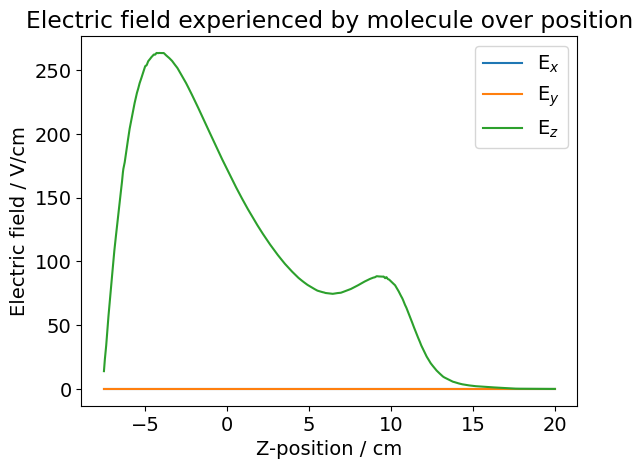

In [8]:
# Plot the electric field as a check:
ts, Es, ax = electric_field.plot(trajectory, position=True)

print(f"Max electric field: {np.max(Es):.2f} V/cm")
print(f"Electric field at z = 0: {E_R(np.array([0, 0, 0]))[2]:.2f} V/cm")


## Define magnetic field
Define the magnetic field. Using a constant field, either a nominal small field (so mF states become non-degenerate eigenstates of the Hamiltonian) or something resembilng Earth's magnetic field.

In [9]:
B = np.array((0, 0, Bz.si.value))


def B_R(R):
    if len(R.shape) == 1:
        return B
    else:
        return B.reshape((3, 1)) * np.ones(R.shape)


magnetic_field = MagneticField(B_R, R_t=trajectory.R_t)


## Initial and final states
Define approximate initial states here.

In [10]:
# Define some useful approximate states
J0_singlet = (
    1
    / np.sqrt(2)
    * (
        1
        * states.UncoupledBasisState(
            J=0,
            mJ=0,
            I1=1 / 2,
            m1=1 / 2,
            I2=1 / 2,
            m2=-1 / 2,
            P=+1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
        - 1
        * states.UncoupledBasisState(
            J=0,
            mJ=0,
            I1=1 / 2,
            m1=-1 / 2,
            I2=1 / 2,
            m2=1 / 2,
            P=+1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
    )
)

J0_triplet_0 = (
    1
    / np.sqrt(2)
    * (
        1
        * states.UncoupledBasisState(
            J=0,
            mJ=0,
            I1=1 / 2,
            m1=1 / 2,
            I2=1 / 2,
            m2=-1 / 2,
            P=+1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
        + 1
        * states.UncoupledBasisState(
            J=0,
            mJ=0,
            I1=1 / 2,
            m1=-1 / 2,
            I2=1 / 2,
            m2=1 / 2,
            P=+1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
    )
)

J0_triplet_p = 1 * states.UncoupledBasisState(
    J=0,
    mJ=0,
    I1=1 / 2,
    m1=1 / 2,
    I2=1 / 2,
    m2=1 / 2,
    P=+1,
    Omega=0,
    electronic_state=states.ElectronicState.X,
)

J0_triplet_m = 1 * states.UncoupledBasisState(
    J=0,
    mJ=0,
    I1=1 / 2,
    m1=-1 / 2,
    I2=1 / 2,
    m2=-1 / 2,
    P=+1,
    Omega=0,
    electronic_state=states.ElectronicState.X,
)

initial_states_approx = [J0_singlet, J0_triplet_m, J0_triplet_0, J0_triplet_p]


In [11]:
# Define some useful approximate states
J1_singlet = (
    1
    / np.sqrt(2)
    * (
        1
        * states.UncoupledBasisState(
            J=1,
            mJ=0,
            I1=1 / 2,
            m1=1 / 2,
            I2=1 / 2,
            m2=-1 / 2,
            P=-1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
        - 1
        * states.UncoupledBasisState(
            J=1,
            mJ=0,
            I1=1 / 2,
            m1=-1 / 2,
            I2=1 / 2,
            m2=1 / 2,
            P=-1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
    )
)

J1_triplet_0 = (
    1
    / np.sqrt(2)
    * (
        1
        * states.UncoupledBasisState(
            J=1,
            mJ=0,
            I1=1 / 2,
            m1=1 / 2,
            I2=1 / 2,
            m2=-1 / 2,
            P=-1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
        + 1
        * states.UncoupledBasisState(
            J=1,
            mJ=0,
            I1=1 / 2,
            m1=-1 / 2,
            I2=1 / 2,
            m2=1 / 2,
            P=-1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
    )
)

J1_triplet_p = 1 * states.UncoupledBasisState(
    J=1,
    mJ=0,
    I1=1 / 2,
    m1=1 / 2,
    I2=1 / 2,
    m2=1 / 2,
    P=-1,
    Omega=0,
    electronic_state=states.ElectronicState.X,
)

J1_triplet_m = 1 * states.UncoupledBasisState(
    J=1,
    mJ=0,
    I1=1 / 2,
    m1=-1 / 2,
    I2=1 / 2,
    m2=-1 / 2,
    P=-1,
    Omega=0,
    electronic_state=states.ElectronicState.X,
)

J1_ppp = 1 * states.UncoupledBasisState(
    J=1,
    mJ=1,
    I1=1 / 2,
    m1=1 / 2,
    I2=1 / 2,
    m2=1 / 2,
    P=-1,
    Omega=0,
    electronic_state=states.ElectronicState.X,
)

J1_pmp = 1 * states.UncoupledBasisState(
    J=1,
    mJ=1,
    I1=1 / 2,
    m1=-1 / 2,
    I2=1 / 2,
    m2=1 / 2,
    P=-1,
    Omega=0,
    electronic_state=states.ElectronicState.X,
)


final_states_approx = [J1_singlet, J1_triplet_m, J1_triplet_0, J1_triplet_p]


In [12]:
J2_singlet = (
    1
    / np.sqrt(2)
    * (
        1
        * states.UncoupledBasisState(
            J=2,
            mJ=0,
            I1=1 / 2,
            m1=1 / 2,
            I2=1 / 2,
            m2=-1 / 2,
            P=1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
        - 1
        * states.UncoupledBasisState(
            J=2,
            mJ=0,
            I1=1 / 2,
            m1=-1 / 2,
            I2=1 / 2,
            m2=1 / 2,
            P=1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
    )
)

J2_triplet_0 = (
    1
    / np.sqrt(2)
    * (
        1
        * states.UncoupledBasisState(
            J=2,
            mJ=0,
            I1=1 / 2,
            m1=1 / 2,
            I2=1 / 2,
            m2=-1 / 2,
            P=1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
        + 1
        * states.UncoupledBasisState(
            J=2,
            mJ=0,
            I1=1 / 2,
            m1=-1 / 2,
            I2=1 / 2,
            m2=1 / 2,
            P=1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
    )
)

J2_triplet_p = 1 * states.UncoupledBasisState(
    J=2,
    mJ=0,
    I1=1 / 2,
    m1=1 / 2,
    I2=1 / 2,
    m2=1 / 2,
    P=1,
    Omega=0,
    electronic_state=states.ElectronicState.X,
)

J2_triplet_m = 1 * states.UncoupledBasisState(
    J=2,
    mJ=0,
    I1=1 / 2,
    m1=-1 / 2,
    I2=1 / 2,
    m2=-1 / 2,
    P=1,
    Omega=0,
    electronic_state=states.ElectronicState.X,
)

# final_states_approx = [J2_singlet, J2_triplet_m, J2_triplet_0, J2_triplet_p]


## Define slowly varying Hamiltonian
Define a Hamiltonian object that represents the slowly varying part of the Hamiltonian (i.e. everything except the microwaves). Using J = 0-3 here since we're interested in the time-evolution of J = 0 and 1 states; J = 0 and 3 are absolutely required since the electric field couples J = 0 to these, J = 3 is not strictly necessary. Since the Stark energies are << the rotational energies, we mostly just need the J of interest $\pm 1$.

In [13]:
Js = [0, 1, 2, 3]
hamiltonian = SlowHamiltonian(Js, trajectory, electric_field, magnetic_field)


## Define microwave Hamiltonian
We will define a microwave field with the following properties
- A Gaussian spatial profile with 1'' intensity FWHM (cylindrically symmetric) 
- propagating along the X-direction
- polarized along the Z-direction
- Calculate power based on the desired Rabi rate for the desired transition

In [14]:
state1 = J0_singlet
state2 = J1_singlet


#### Center position

In [15]:
R0 = np.array([0.0, 0, 0.0])

#### Polarization:

In [16]:
# Define a function that gives the main component of the polarization as a function of position
p_main = couplings.polarization_Z
P_R = lambda R: p_main.vector

# Define k-vector
k = np.array((1, 0, 0))

pol = Polarization(P_R, k, f_long=1)


#### Frequency
Calculate the microwave frequency between specified states at a specific point

In [17]:
muW_freq = calculate_transition_frequency(
    state1, state2, hamiltonian.H_R(R0), hamiltonian.QN
)


In [18]:
print(f"Transition frequency at center of microwaves: {muW_freq / 1e9:.5f} GHz")

Transition frequency at center of microwaves: 13.34005 GHz


#### Intensity profile:

In [19]:
# Define a Gaussian intensity profile
intensity_01 = GaussianBeam(
    power=1e-3,
    sigma=utils.rabi.fwhm_to_sigma(mu_fwhm.si.value),
    R0=R0,
    k=k,
    freq=muW_freq,
)


#### Define MicrowaveField

In [20]:
mf01 = MicrowaveField(0, 1, intensity_01, pol, muW_freq, hamiltonian.QN)

### J = 0 to 1 background field
Defining a field that has uniform intensity everywhere to represent microwaves randomly scattering of the vacuum chamber, windows etc

In [21]:
# Define polarization components

# Define a function that gives the main component of the polarization as a function of position
p = (couplings.polarization_Z + (0.4 * couplings.polarization_Y)).normalize()
P_R = lambda R: p.vector


pol_bg = Polarization(p_R_main=P_R)

# Define a background intensity profile
lims = [
    (-1, 1),
    (-1, 1),
    (-1, 1),
]
intensity_01_bg = BackgroundField(lims, intensity=mf01.intensity.I_R(R0) / 100)

mf01_bg = MicrowaveField(
    0, 1, intensity_01_bg, pol_bg, muW_freq, hamiltonian.QN, background_field=True
)


### RC background field

In [22]:
muW_rc_freq = calculate_transition_frequency(
    J1_singlet,
    J2_singlet,
    hamiltonian.H_R(np.array([0, 0, z_start.si.value])),
    hamiltonian.QN,
)
print(f"Transition frequency at 0 V/cm: {muW_rc_freq / 1e9:.5f} GHz")


Transition frequency at 0 V/cm: 26.66937 GHz


In [23]:
pol_bg_rc = Polarization(P_R)

# Define a Gaussian intensity profile
lims = [
    (-1, 1),
    (-1, 1),
    (-1, 1),
]
intensity_bg_rc = BackgroundField(lims, intensity=mf01.intensity.I_R(R0) / 100)

mf12_rc_bg = MicrowaveField(
    1, 2, intensity_bg_rc, pol_bg_rc, muW_rc_freq, hamiltonian.QN, background_field=True
)


# Simulation

In [24]:
# Set microwave parameters
## Center postion
## Sigma
mf01.intensity.sigma = utils.rabi.fwhm_to_sigma(mu_fwhm.si.value)

## Frequency
freq_main = calculate_transition_frequency(
    state1, state2, hamiltonian.H_R(R0), hamiltonian.QN
)
detuning = 0e6
mf01.set_frequency(freq_main + detuning)
mf01_bg.set_frequency(freq_main + detuning)
mf01.set_position(R0)

## Power
mf01.set_power(2e-4)
mf01_bg.intensity.intensity = mf01.intensity.I_R(R0) / 100
mf12_rc_bg.intensity.intensity = 1e-3
mf12_rc_bg.set_frequency(
    calculate_transition_frequency(
        J1_singlet,
        J2_singlet,
        hamiltonian.H_R(np.array((0.0, 0.0, z_start.si.value))),
        hamiltonian.QN,
    )
)


# Molecule parameters
trajectory.Rini = np.array([0, 0.00, z_start.si.value])
trajectory.Vini = np.array([0, 0, v_forward.si.value])

microwave_fields = [mf01, mf01_bg, mf12_rc_bg]


In [25]:
simulator = Simulator(
    trajectory,
    electric_field,
    magnetic_field,
    initial_states_approx,
    hamiltonian,
    microwave_fields,
)


In [26]:
result = simulator.run(N_steps=10_000)

  1%|          | 62/9999 [00:00<00:53, 184.75it/s]

100%|██████████| 9999/9999 [00:45<00:00, 218.34it/s]


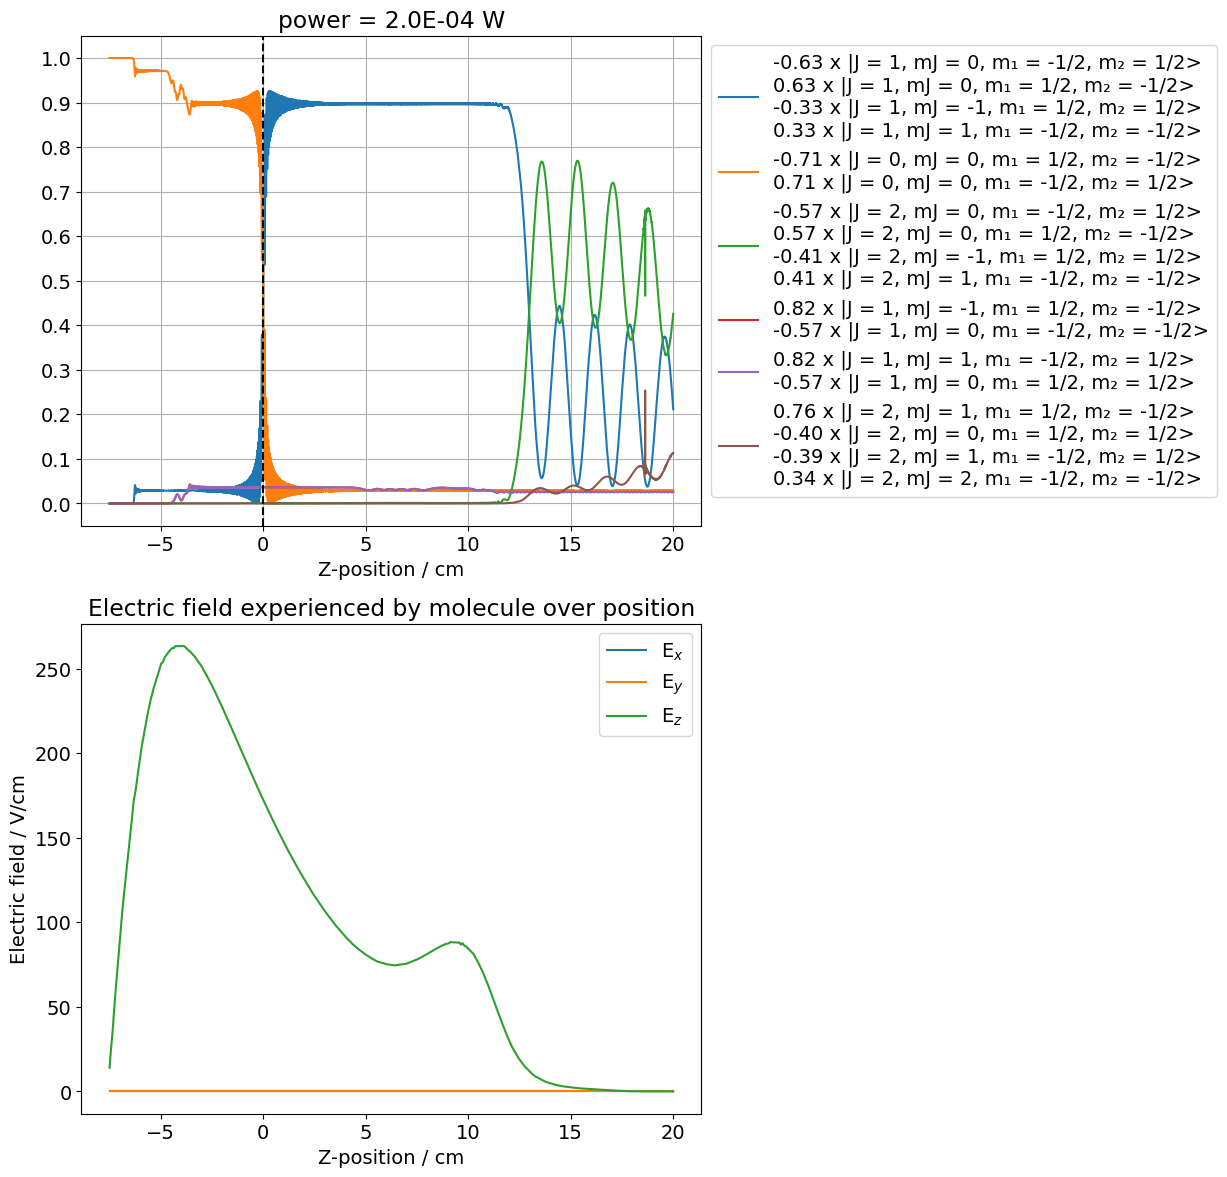

In [27]:
initial_state = result.initial_states[0]
large_prob_states = result.find_large_prob_states(initial_state, N=6)
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(8, 14))
result.plot_state_probabilities(large_prob_states, initial_state, ax=ax, position=True)
ax.set_yticks(np.arange(0, 1.01, 0.1))
ax.legend(fontsize=14, bbox_to_anchor=(1.0, 1))
ax.axvline(x=R0[2] * 1e2, ls="--", c="k")
ax.set_title(f"power = {mf01.intensity.power:.1E} W")
ax.grid()

_ = electric_field.plot(trajectory, position=True, ax=ax2)


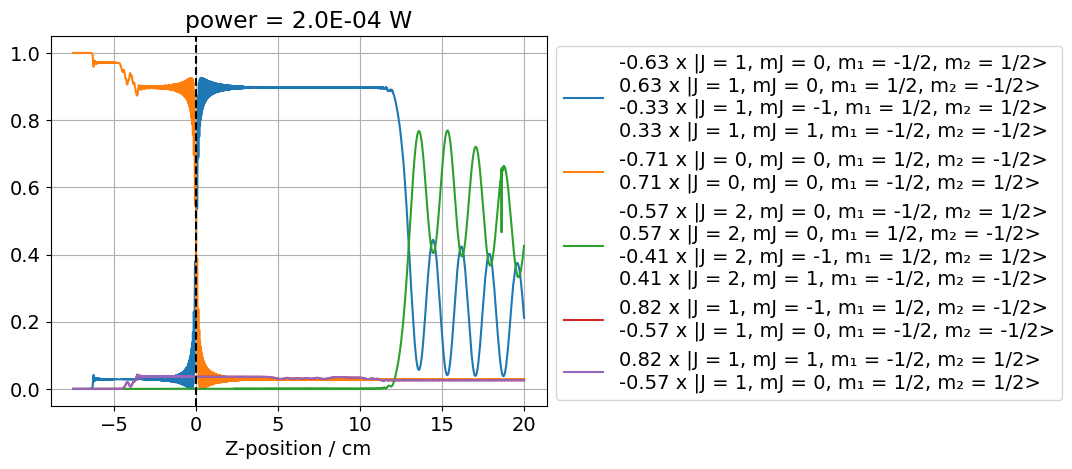

In [ ]:
initial_state = result.initial_states[0]
large_prob_states = result.find_large_prob_states(initial_state, N=5)
fig, ax = plt.subplots()
result.plot_state_probabilities(large_prob_states, initial_state, ax=ax, position=True)
ax.legend(fontsize=14, bbox_to_anchor=(1.0, 1))
ax.axvline(x=R0[2] * 1e2, ls="--", c="k")
ax.set_title(f"power = {mf01.intensity.power:.1E} W")
ax.grid()


## Parameter Scans

In [ ]:
def run_simulation(
    power_spa1: float,
    intensity_spa1_bg_fraction: float,
    intensity_rc_bg: float,
    detuning_spa1: float,
    detuning_rc_bg: float,
    v_forward: float,
    initial_state_idx: int,
    target_state: states.CoupledState,
    N_steps=10_000,
) -> tuple[float, float, float, float, float, float, float, float]:
    """
    Runs the simulation for one value of power and finds the probability of ending up in the target state.
    """
    # set frequency spa1
    freq_spa1 = calculate_transition_frequency(
        state1,
        state2,
        hamiltonian.H_R(R0),
        hamiltonian.QN,
    )
    mf01.set_frequency(freq_spa1 + detuning_spa1)
    mf01_bg.set_frequency(freq_spa1 + detuning_spa1)

    # Set frequency rc bg
    freq_rc_bg = calculate_transition_frequency(
        J1_singlet,
        J2_singlet,
        hamiltonian.H_R(np.array([0.0, 0.0, z_start.si.value])),
        hamiltonian.QN,
    )
    mf12_rc_bg.set_frequency(freq_rc_bg + detuning_rc_bg)

    # set powers & intensities
    mf01.set_power(power_spa1)
    mf01_bg.intensity.intensity = mf01.intensity.I_R(R0) * intensity_spa1_bg_fraction
    mf12_rc_bg.intensity.intensity = intensity_rc_bg

    # Run the simulator
    microwave_fields = [mf01, mf01_bg, mf12_rc_bg]

    # trajectories
    trajectory.Vini[-1] = v_forward

    simulator = Simulator(
        trajectory,
        electric_field,
        magnetic_field,
        initial_states_approx,
        hamiltonian,
        microwave_fields,
    )

    result = simulator.run(N_steps=N_steps)

    # Determine probability to be in initial state
    prob_ini = float(
        result.get_state_probability(
            result.initial_states[initial_state_idx],
            initial_state=result.initial_states[initial_state_idx],
        )[-1]
    )

    # Determine probability to be in target state
    prob_fin = float(
        result.get_state_probability(
            target_state, initial_state=result.initial_states[initial_state_idx]
        )[-1]
    )

    return (
        power_spa1,
        intensity_spa1_bg_fraction,
        intensity_rc_bg,
        detuning_spa1,
        detuning_rc_bg,
        v_forward,
        prob_ini,
        prob_fin,
    )


header = "SPA1 power, SPA1 bg fraction, RC bg intensity, SPA1 detuning, RC detuning, v_forward, prob ini, prob fin".split(
    ","
)
header = [val.strip(" ") for val in header]


### Scan SPA1 power

In [143]:
powers = np.logspace(-6, -3, 51)

res = Parallel(n_jobs=nr_cores, verbose=1)(
    delayed(run_simulation)(
        power_spa1=power,
        intensity_spa1_bg_fraction=0.0,
        intensity_rc_bg=0.0,
        detuning_spa1=0.0,
        detuning_rc_bg=0.0,
        v_forward=184.0,
        initial_state_idx=0,
        target_state=J1_singlet,
    )
    for power in powers
)


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  5.6min
[Parallel(n_jobs=8)]: Done  51 out of  51 | elapsed:  7.6min finished


In [144]:
power_scan = np.array(res).copy()

fname = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + "_spa1_scan_power.csv"

df = pl.DataFrame(power_scan, schema=header)


df.write_csv(path_data / fname)


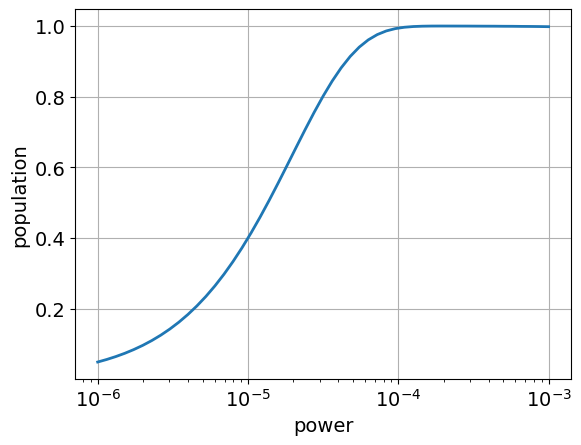

In [145]:
fig, ax = plt.subplots()
ax.plot(powers, power_scan[:, -1], lw=2)
ax.set_xscale("log")
ax.set_xlabel("power")
ax.set_ylabel("population")
ax.grid()


### Scan RC bg intensity

In [139]:
background_intensity = np.logspace(-5, np.log10(mf01.intensity.I_R(R0)), 51)

res = Parallel(n_jobs=nr_cores, verbose=1)(
    delayed(run_simulation)(
        power_spa1=2e-4,
        intensity_spa1_bg_fraction=1 / 100,
        intensity_r.c_bg=intens,
        detuning_spa1=0.0,
        detuning_rc_bg=0.0,
        v_forward=184.0,
        initial_state_idx=0,
        target_state=J1_singlet,
    )
    for intens in background_intensity
)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


MemoryError: Unable to allocate 39.1 MiB for an array with shape (10000, 4, 64) and data type complex128

In [31]:
bg_power_scan = np.array(res).copy()

fname = (
    datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    + "_spa1_scan_rc_bg_intensity.csv"
)

df = pl.DataFrame(bg_power_scan, schema=header)


df.write_csv(path_data / fname)


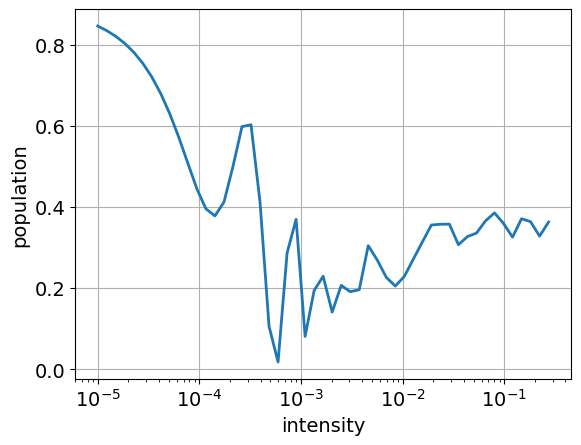

In [ ]:
fig, ax = plt.subplots()
ax.plot(background_intensity, bg_power_scan[:, -1], lw=2)
ax.set_xscale("log")
ax.set_xlabel("intensity")
ax.set_ylabel("population")
ax.grid()


### Scan RC bg intensity and frequency

In [33]:
intensities = np.logspace(-6, 0, 51)
detunings = np.linspace(-13, 13, 61) * 1e6

res = []
for intens in tqdm.tqdm(intensities):
    res.append(
        np.array(
            Parallel(n_jobs=nr_cores, verbose=0)(
                delayed(run_simulation)(
                    power_spa1=2e-4,
                    intensity_spa1_bg_fraction=1 / 100,
                    intensity_rc_bg=intens,
                    detuning_spa1=0.0,
                    detuning_rc_bg=det,
                    v_forward=184.0,
                    initial_state_idx=0,
                    target_state=J1_singlet,
                )
                for det in detunings
            )
        )
    )


100%|██████████| 51/51 [4:07:14<00:00, 290.88s/it]  


In [34]:
bg_detuning_scan = (
    np.array(res).copy().reshape(intensities.size, detunings.size, res[0].shape[-1])
)

fname = (
    datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    + "_spa1_scan_rc_bg_intensity_detuning.csv"
)

df = pl.DataFrame(bg_detuning_scan.reshape(-1, res[0].shape[-1]), schema=header)


df.write_csv(path_data / fname)


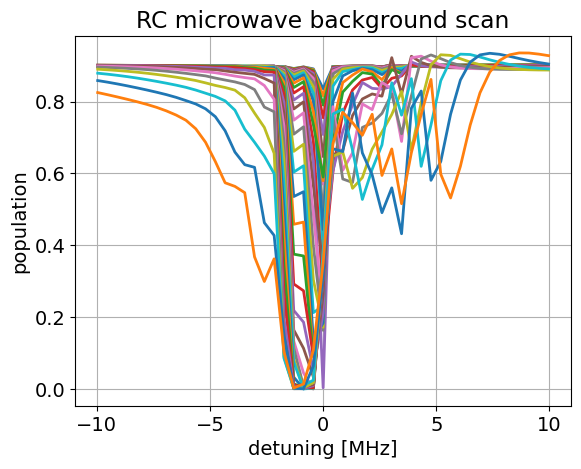

In [130]:
detunings = np.unique(bg_detuning_scan[0, :, 4])
det_mask = (detunings >= -10e6) & (detunings <= 10e6)
# det_mask = np.ones(detunings.size, dtype=np.bool)
fig, ax = plt.subplots()

ax.plot(
    detunings[det_mask] / 1e6,
    bg_detuning_scan[9:, det_mask, -1].T,
    lw=2,
    label=[f"{val:.1e}" for val in intensities[9:]],
)

ax.set_xlabel("detuning [MHz]")
ax.set_ylabel("population")
ax.set_title("RC microwave background scan")
# ax.legend()

ax.grid()


### Scan SPA1 frequency and bg fraction

In [36]:
bg_fraction = np.logspace(-3, 0, 11)
detunings = np.linspace(-13, 13, 61) * 1e6

res = []
for frac in tqdm.tqdm(bg_fraction):
    res.append(
        np.array(
            Parallel(n_jobs=nr_cores, verbose=0)(
                delayed(run_simulation)(
                    power_spa1=2e-4,
                    intensity_spa1_bg_fraction=frac,
                    intensity_rc_bg=4e-3,
                    detuning_spa1=det,
                    detuning_rc_bg=0.0,
                    v_forward=184.0,
                    initial_state_idx=0,
                    target_state=J1_singlet,
                )
                for det in detunings
            )
        )
    )


100%|██████████| 11/11 [52:56<00:00, 288.74s/it]


In [37]:
fname = (
    datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    + "_spa1_scan_spa1_bg_intensity_fraction_detuning.csv"
)

spa1_bg_intens_detuning_scan = (
    np.array(res).copy().reshape(bg_fraction.size, detunings.size, res[0].shape[-1])
)

df = pl.DataFrame(
    spa1_bg_intens_detuning_scan.reshape(-1, res[0].shape[-1]), schema=header
)


df.write_csv(path_data / fname)


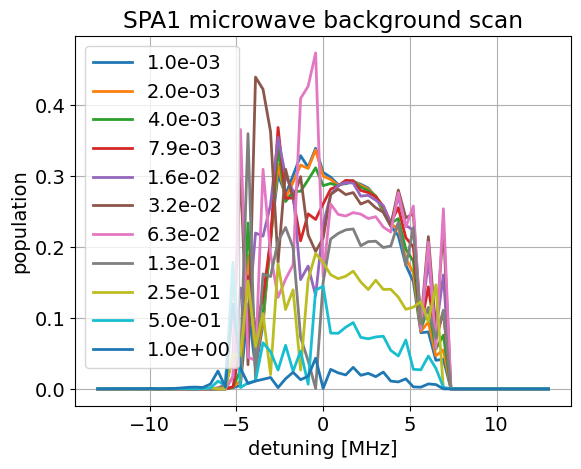

In [38]:
detunings = np.unique(spa1_bg_intens_detuning_scan[0, :, 3])

det_mask = (detunings >= -5e6) & (detunings <= 5e6)
det_mask = np.ones(detunings.size, dtype=np.bool)
fig, ax = plt.subplots()

ax.plot(
    detunings[det_mask] / 1e6,
    spa1_bg_intens_detuning_scan[:, det_mask, -1].T,
    lw=2,
    label=[f"{val:.1e}" for val in bg_fraction[:]],
)

ax.set_xlabel("detuning [MHz]")
ax.set_ylabel("population")
ax.set_title("SPA1 microwave background scan")
ax.legend()

ax.grid()


### Scan forward velocity, SPA1 frequency and bg fraction 

In [39]:
velocities = (
    np.linspace(-2 * v_foward_sigma.si.value, 2 * v_foward_sigma.si.value, 11)
    + v_forward.si.value
)
bg_fraction = np.logspace(-3, np.log10(0.25), 5)
detunings = np.linspace(-13, 13, 51) * 1e6

res = []
for vel in tqdm_notebook(velocities):
    for frac in tqdm_notebook(bg_fraction, leave=False):
        res.append(
            np.array(
                Parallel(n_jobs=nr_cores, verbose=0)(
                    delayed(run_simulation)(
                        power_spa1=2e-4,
                        intensity_spa1_bg_fraction=frac,
                        intensity_rc_bg=4e-3,
                        detuning_spa1=det,
                        detuning_rc_bg=0.0,
                        v_forward=vel,
                        initial_state_idx=0,
                        target_state=J1_singlet,
                    )
                    for det in detunings
                )
            )
        )


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [40]:
fname = (
    datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    + "_spa1_scan_spa1_velocity_bg_intensity_fraction_detuning.csv"
)

spa1_vel_bg_intens_detuning_scan = (
    np.array(res)
    .copy()
    .reshape(bg_fraction.size * velocities.size, detunings.size, res[0].shape[-1])
)

df = pl.DataFrame(
    spa1_vel_bg_intens_detuning_scan.reshape(-1, res[0].shape[-1]), schema=header
)


df.write_csv(path_data / fname)


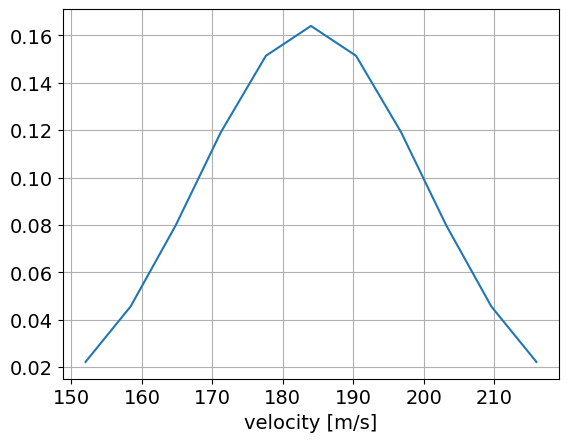

In [56]:
kernel = stats.norm.pdf(
    velocities, loc=v_forward.si.value, scale=v_foward_sigma.si.value
)
kernel /= kernel.sum()

fig, ax = plt.subplots()
ax.plot(velocities, kernel)
ax.set_xlabel("velocity [m/s]")
ax.grid()


In [78]:
dat = spa1_vel_bg_intens_detuning_scan.reshape(
    velocities.size, bg_fraction.size, detunings.size, len(header)
).copy()


In [103]:
d = np.tensordot(kernel, dat[:, :, :, -1], axes=([0], [0]))

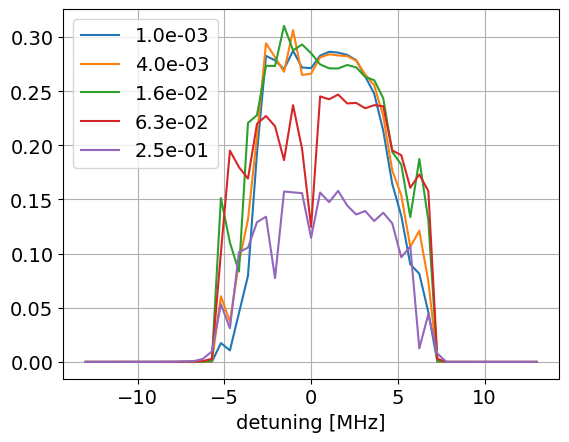

In [104]:
fig, ax = plt.subplots()

ax.plot(detunings / 1e6, d.T, label=[f"{val:.1e}" for val in bg_fraction])

ax.set_xlabel("detuning [MHz]")
ax.legend()

ax.grid()


#### Convolve with microwave transition linewidth

In [131]:
# microwave transition linewidth
linewidth = 1.0e6  # Hz
kernel_det = stats.norm.pdf(
    detunings, loc=0.0, scale=linewidth / (2 * np.sqrt(2 * np.log(2)))
)
kernel_det /= kernel_det.sum()


In [132]:
conv = np.apply_along_axis(
    lambda row: np.convolve(row, kernel_det, mode="same"), axis=1, arr=d
)


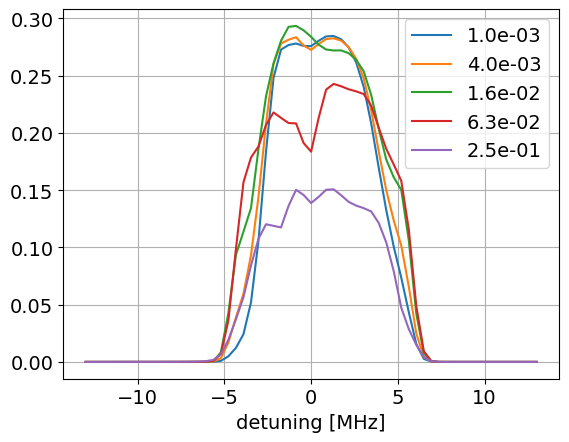

In [133]:
fig, ax = plt.subplots()

ax.plot(detunings / 1e6, conv.T, label=[f"{val:.1e}" for val in bg_fraction])

ax.set_xlabel("detuning [MHz]")
ax.legend()

ax.grid()


### Scan forward velocity RC bg frequency, RC bg intensity

In [1]:
velocities = (
    np.linspace(-2 * v_foward_sigma.si.value, 2 * v_foward_sigma.si.value, 15)
    + v_forward.si.value
)
intensities = np.logspace(-4, -1, 11)
detunings = np.linspace(-13, 13, 61) * 1e6

res = []
for vel in tqdm_notebook(velocities):
    for intens in tqdm_notebook(intensities, leave=False):
        res.append(
            np.array(
                Parallel(n_jobs=nr_cores, verbose=0)(
                    delayed(run_simulation)(
                        power_spa1=2e-4,
                        intensity_spa1_bg_fraction=1 / 100,
                        intensity_rc_bg=intens,
                        detuning_spa1=0.0,
                        detuning_rc_bg=det,
                        v_forward=vel,
                        initial_state_idx=0,
                        target_state=J1_singlet,
                    )
                    for det in detunings
                )
            )
        )


NameError: name 'np' is not defined

In [ ]:
fname = (
    datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    + "_spa1_scan_spa1_velocity_rc_bg_intensity_rc_detuning.csv"
)

spa1_vel_bg_intens_detuning_scan = (
    np.array(res)
    .copy()
    .reshape(intensities.size * velocities.size, detunings.size, res[0].shape[-1])
)

df = pl.DataFrame(
    spa1_vel_bg_intens_detuning_scan.reshape(-1, res[0].shape[-1]), schema=header
)


df.write_csv(path_data / fname)
